<a href="https://colab.research.google.com/github/tkhemka06/Frame-Level-Speech-Recognition-with-MLP/blob/main/Frame-Level%20Speech%20Recognition%20with%20MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

_11785_spring_25_hw_1_p_2_path = kagglehub.competition_download('11785-spring-25-hw-1-p-2')

print('Data source import complete.')


100%|██████████| 3.98G/3.98G [03:03<00:00, 23.3MB/s]

Extracting files...


Data source import complete.


# HW1: Frame-Level Speech Recognition

In this homework, you will be working with MFCC data consisting of 28 features at each time step/frame. Your model should be able to recognize the phoneme occured in that frame.

# Dataset Description

Let's start by understanding the dataset for this homework.

Our data consists of 3 folders (train-clean-100, dev-clean and test-clean). The training and validation datasets (train-clean-100 and dev-clean) each contain 2 subfolders (mfcc and transcript). The 'mfcc' subfolder contains mel spectrograms (explained below and in writeup), while the 'transcript' subfolder contains their corresponding transcripts. However, the test dataset (test-clean) contains only the 'mfcc' subfolder without the corresponding transcripts, which will later be predicted by your model.


## 1. Audio Representation.
The 'mfcc' subfolders contain many `*.npy` files of mel spectrograms. .npy files are used to store numpy arrays.

Each .npy file represents a short speech recording. For example, one recording might be someone saying, "This is the age of AI." This recording is converted into a mel spectrogram, which is used to represent all forms of audio signals in a computer. Such representation is important in signal and speech processing tasks, especially in machine learning.

Compared to raw audio, mel spectrograms are better for speech processing because they capture both the timing and the frequencies of the sound. At each moment in time, they show which frequencies are present in the sound. This makes it easier for computers to understand and process speech.

When converting raw audio to spectrograms, you do not process the whole audio at once. Instead, you process small frames at a time as you stride over the entire audio length. This means that if you have an audio file of 100 seconds, you may decide to process 10 seconds at a time, striding by one second. In this case, the frame size is 10 seconds. The frame size and the number of timesteps (seconds, milliseconds, etc.) depend on individual choice.

When processing each frame, you extract a number of features that represent that frame's audio. For instance, in the audio recording of "This is the age of AI," the frame corresponding to "AI" will have features that represent how "AI" is pronounced, the vocal tract, and the effect of the environment in which it was recorded. For clarity, when we say features, you should think of columns. One feature/column may have information about the gender of the person who made the speech. Another may have information about the age of the person. Another may have information about the environment where the speech was recorded. Basically, the main properties that make up a speech are encoded in those features, which combine in some way to make the audio.

Since we want to recognize the word as it was pronounced despite the environment and other variabilities, we usually normalize to eliminate or minimize such effects.

Our spectrograms contain 28 features. Essentially, the number of features may be different. They may depend on how the raw audio data was converted into mel spectrograms.

## 2. Transcripts
Remember where we mentioned frames? Well, in our dataset, audio frames have corresponding target transcripts. For instance the abbreviation "AI", in our example above, if present in the recordings, will have transcripts: /eɪ aɪ/. This means that you will have two frames one for  /eɪ/ and another for /aɪ/.

This way of representing pronounciation in text form is called ***phonetic transcription***, "the conversion of spoken words the way they are pronounced instead of how they are written"[[link]](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://krisp.ai/blog/phonetic-transcription/%23:~:text%3Dphonetic%2520transcriptions%2520done.-,What%2520are%2520Phonetic%2520Transcriptions%253F,verbatim%2520to%2520intelligent%2520verbatim%2520transcriptions.&ved=2ahUKEwiV6LO6hrSHAxUKSvEDHcvwAAsQFnoECB0QAw&usg=AOvVaw0VqoWceOzdVwe-AvdyyWqJ). In this case letters 'A' and 'I' are pronounce /eɪ/ and /aɪ/, respectively. Both letters in different words may be pronounced differently.

The produced representation of the speech is referred to as phonemes. Various .npy files that contain recordings of the sentence **"This is the age of AI."** would map to **"/ðɪs ɪz ðə eɪdʒ əv eɪ aɪ/."** The phonemes representation for **Chelsea sucks** would be **/ˈtʃɛl.si sʌks/**

Going inside the .npy files. Each .npy file contains vectors which have 28 features/dimensions/columns. The number of vectors in the file corresponds to the number of frames in the recording. And each single frame has a corresponding phoneme in the transcript.

For instance the .npy file for "This is the age of AI" --> "/ðɪs ɪz ðə eɪdʒ əv eɪ aɪ/" might have 13 frames (13 vectors):

- /ðɪs/ has 3 phonemes: /ð/, /ɪ/, /s/  
- /ɪz/ has 2 phonemes: /ɪ/, /z/
- /ðə/ has 2 phonemes: /ð/, /ə/
- /eɪdʒ/ has 2 phonemes: /eɪ/, /dʒ/
- /əv/ has 2 phonemes: /ə/, /v/
- /eɪ aɪ/ has 2 phonemes: /eɪ/, /aɪ/

**Chelsea sucks** --> **/ˈtʃɛl.si sʌks/** might have 8 frames (8 vectors):

- /ˈtʃɛl.si/ has 4 phonemes: /tʃ/, /ɛ/, /l/, /si/
- /sʌks/ has 4 phonemes: /s/, /ʌ/, /k/, /s/

Note that recordings of different sentences may have different number of frames.

The model you will produce must take a vector of a particular frame and predict the frame's transcript as accurately as possible.

Therefore, the **__getitem__** method of your dataset class must return a 28 dimensional vector of a particular frame and its corresponding phoneme transcript.

This means that, while you are doing your data preprocessing in the **__init__** method, you need stack all vectors from all recordings on top of each other. You must do this for all transcripts as well and remember to ensure the correspondance between frames and their phoneme mapping is maintained.

For our dataset of two samples above, if you stack the recordings together, you get:


| Frame | Feature 1 | Feature 2 | ... | Feature 28 | Phoneme |
|-------|-----------|-----------|-----|------------|---------|
| 0     | v0_1      | v0_2      | ... | v0_28      | /ð/     |
| 1     | v1_1      | v1_2      | ... | v1_28      | /ɪ/     |
| 2     | v2_1      | v2_2      | ... | v2_28      | /s/     |
| 3     | v3_1      | v3_2      | ... | v3_28      | /ɪ/     |
| 4     | v4_1      | v4_2      | ... | v4_28      | /z/     |
| 5     | v5_1      | v5_2      | ... | v5_28      | /ð/     |
| 6     | v6_1      | v6_2      | ... | v6_28      | /ə/     |
| 7     | v7_1      | v7_2      | ... | v7_28      | /eɪ/    |
| 8     | v8_1      | v8_2      | ... | v8_28      | /dʒ/    |
| 9     | v9_1      | v9_2      | ... | v9_28      | /ə/     |
| 10    | v10_1     | v10_2     | ... | v10_28     | /v/     |
| 11    | v11_1     | v11_2     | ... | v11_28     | /eɪ/    |
| 12    | v12_1     | v12_2     | ... | v12_28     | /aɪ/    |
| 13    | v13_1     | v13_2     | ... | v13_28     | /tʃ/    |
| 14    | v14_1     | v14_2     | ... | v14_28     | /ɛ/     |
| 15    | v15_1     | v15_2     | ... | v15_28     | /l/     |
| 16    | v16_1     | v16_2     | ... | v16_28     | /si/     |
| 17    | v17_1     | v17_2     | ... | v17_28     | /s/     |
| 18    | v18_1     | v18_2     | ... | v18_28     | /ʌ/     |
| 19    | v19_1     | v19_2     | ... | v19_28     | /k/     |
| 20    | v20_1     | v20_2     | ... | v20_28     | /s/     |


So, if you pass index 5 to **__getitem__**, you will get back vector v5 (v5_1, v5_2, ..., v5_28) and transcript **/ð/**. Ideally, if you have a well trained model, it should take v5 and return **/ð/**. And the call to **__len__** would return 21 which the training loop would use to go through the whole dataset.

## Context

In the dataset we are using, a few millisecs were used to convert raw audio to mel spectrogram and extract the 28 features.
Since each vector represents only a few millisecs of speech, it may not be sufficient to feed only a single vector into the network at a time. Instead, it may be useful to provide the network with some “context” of size K around each vector in terms of additional vectors from the speech input.

Concretely, a context of size 3 would mean that we provide an input of size (7, 28) to the network - the size 7 can be explained as: the vector to predict the label for, 3 vectors preceding this vector, and 3 vectors following it. It is worth thinking about how you would handle providing context before one of the first K frames of an utterance or after one of the last K frames.

There are several ways to implement this, but you could try the simplest one:
- Concatenating all utterances and padding with K 0-valued vectors before and after the resulting matrix

If you use a context of 3 on the above table, you get the following table:

| Frame | Feature 1 | Feature 2 | ... | Feature 28 | Phoneme | Context Vectors |
|-------|-----------|-----------|-----|------------|---------|----------------|
| 0     | v0_1      | v0_2      | ... | v0_28      | /ð/     | [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding), v0, v1, v2, v3 |
| 1     | v1_1      | v1_2      | ... | v1_28      | /ɪ/     | [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding), v0, v1, v2, v3, v4 |
| 2     | v2_1      | v2_2      | ... | v2_28      | /s/     | [0, 0, 0, ..., 0] (Padding), v0, v1, v2, v3, v4, v5 |
| 3     | v3_1      | v3_2      | ... | v3_28      | /ɪ/     | v0, v1, v2, v3, v4, v5, v6 |
| 4     | v4_1      | v4_2      | ... | v4_28      | /z/     | v1, v2, v3, v4, v5, v6, v7 |
| 5     | v5_1      | v5_2      | ... | v5_28      | /ð/     | v2, v3, v4, v5, v6, v7, v8 |
| 6     | v6_1      | v6_2      | ... | v6_28      | /ə/     | v3, v4, v5, v6, v7, v8, v9 |
| 7     | v7_1      | v7_2      | ... | v7_28      | /eɪ/    | v4, v5, v6, v7, v8, v9, v10 |
| 8     | v8_1      | v8_2      | ... | v8_28      | /dʒ/    | v5, v6, v7, v8, v9, v10, v11 |
| 9     | v9_1      | v9_2      | ... | v9_28      | /ə/     | v6, v7, v8, v9, v10, v11, v12 |
| 10    | v10_1     | v10_2     | ... | v10_28     | /v/     | v7, v8, v9, v10, v11, v12, v13 |
| 11    | v11_1     | v11_2     | ... | v11_28     | /eɪ/    | v8, v9, v10, v11, v12, v13, v14 |
| 12    | v12_1     | v12_2     | ... | v12_28     | /aɪ/    | v9, v10, v11, v12, v13, v14, v15 |
| 13    | v13_1     | v13_2     | ... | v13_28     | /tʃ/    | v10, v11, v12, v13, v14, v15, v16 |
| 14    | v14_1     | v14_2     | ... | v14_28     | /ɛ/     | v11, v12, v13, v14, v15, v16, v17 |
| 15    | v15_1     | v15_2     | ... | v15_28     | /l/     | v12, v13, v14, v15, v16, v17, v18 |
| 16    | v16_1     | v16_2     | ... | v16_28     | /s/     | v13, v14, v15, v16, v17, v18, v19 |
| 17    | v17_1     | v17_2     | ... | v17_28     | /i/     | v14, v15, v16, v17, v18, v19, v20 |
| 18    | v18_1     | v18_2     | ... | v18_28     | /s/     | v15, v16, v17, v18, v19, v20, v21 |
| 19    | v19_1     | v19_2     | ... | v19_28     | /ʌ/     | v16, v17, v18, v19, v20, v21, [0, 0, 0, ..., 0] (Padding) |
| 20    | v20_1     | v20_2     | ... | v20_28     | /k/     | v17, v18, v19, v20, v21, [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding) |
| 21    | v21_1     | v21_2     | ... | v21_28     | /s/     | v18, v19, v20, v21, [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding), [0, 0, 0, ..., 0] (Padding) |


Now, if you want to predict the output of vector v5, you won't just pass vector v5 alone. You will concatenate 3 vectors before it and 3 vectors after, which makes it 7 vectors ([v2, v3, v4, v5, v6, v7, v8 ]) . This needs to be reflected in your **__getitem__** method. Meaning it should return an array of shape (7, 28), in this example.

Hence your model is going to be taking a tensor (array) of shape (7, 28) in this example.

# Libraries

In [35]:
!pip install torchsummaryX==1.1.0 wandb --quiet

In [36]:
!pip install torchaudio --quiet

In [37]:
import torch
import torch.nn as nn
import numpy as np
from torchsummaryX import summary
import sklearn
import gc
import zipfile
import bisect
import pandas as pd
from tqdm.auto import tqdm
import os
import datetime
import wandb
import yaml
import torchaudio.transforms as tat
import torch.nn.functional as F
import torchaudio
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


# Mount Google Drive

In [38]:
''' If you are using colab, you can import google drive to save model checkpoints in a folder
    If you want to use it, uncomment the two lines below
'''
# from google.colab import drive
# drive.mount('/content/drive')

' If you are using colab, you can import google drive to save model checkpoints in a folder\n    If you want to use it, uncomment the two lines below\n'

In [39]:
### PHONEME LIST
PHONEMES = [
            '[SIL]',   'AA',    'AE',    'AH',    'AO',    'AW',    'AY',
            'B',     'CH',    'D',     'DH',    'EH',    'ER',    'EY',
            'F',     'G',     'HH',    'IH',    'IY',    'JH',    'K',
            'L',     'M',     'N',     'NG',    'OW',    'OY',    'P',
            'R',     'S',     'SH',    'T',     'TH',    'UH',    'UW',
            'V',     'W',     'Y',     'Z',     'ZH',    '[SOS]', '[EOS]']

# Kaggle

This section contains code that helps you install kaggle's API, creating kaggle.json with you username and API key details. Make sure to input those in the given code to ensure you can download data from the competition successfully.

In [40]:
!pip install --upgrade kaggle==1.6.17 --force-reinstall --no-deps
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    # Put your kaggle username & key here
    f.write('{"username":"tanishakhemka","key":"2dc09129a6b5ad562b5e1c7815ee6166"}')

!chmod 600 /root/.kaggle/kaggle.json

  Using cached kaggle-1.6.17-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [41]:
# commands to download data from kaggle
!kaggle competitions download -c 11785-spring-25-hw-1-p-2

# Unzip downloaded data
!unzip -qo /content/11785-spring-25-hw-1-p-2.zip -d '/content'

11785-spring-25-hw-1-p-2.zip: Skipping, found more recently modified local copy (use --force to force download)


In [42]:
!ls /content/11785-s25-hw1p2

dev-clean  test-clean  train-clean-100


In [43]:
!ls /content/11785-s25-hw1p2/train-clean-100

mfcc  transcript


# Parameters Configuration

Storing your parameters and hyperparameters in a single configuration dictionary makes it easier to keep track of them during each experiment. It can also be used with weights and biases to log your parameters for each experiment and keep track of them across multiple experiments.

In [44]:
config = {
    'Name': 'Tanisha Khemka', # Write your name here
    'subset': 1.0, # Subset of dataset to use (1.0 == 100% of data)
    'context': 30,
    'archetype': 'diamond', # Default Values: pyramid, diamond, inverse-pyramid,cylinder
    'activations': 'GELU',
    'learning_rate': 0.001,
    'dropout': 0.25,
    'optimizers': 'SGD',
    'scheduler': 'ReduceLROnPlateau',
    'epochs': 15,
    'batch_size': 2048,
    'weight_decay': 0.05,
    'weight_initialization': None, # e.g kaiming_normal, kaiming_uniform, uniform, xavier_normal or xavier_uniform
    'augmentations': 'Both', # Options: ["FreqMask", "TimeMask", "Both", null]
    'freq_mask_param': 4,
    'time_mask_param': 8
 }

In [45]:
config

{'Name': 'Tanisha Khemka',
 'subset': 1.0,
 'context': 30,
 'archetype': 'diamond',
 'activations': 'GELU',
 'learning_rate': 0.001,
 'dropout': 0.25,
 'optimizers': 'SGD',
 'scheduler': 'ReduceLROnPlateau',
 'epochs': 15,
 'batch_size': 2048,
 'weight_decay': 0.05,
 'weight_initialization': None,
 'augmentations': 'Both',
 'freq_mask_param': 4,
 'time_mask_param': 8}

# Dataset Class

This section covers the dataset/dataloader class for speech data. You will have to spend time writing code to create this class successfully. We have given you a lot of comments guiding you on what code to write at each stage, from top to bottom of the class. Please try and take your time figuring this out, as it will immensely help in creating dataset/dataloader classes for future homeworks.

Before running the following cells, please take some time to analyse the structure of data. Try loading a single MFCC and its transcipt, print out the shapes and print out the values. Do the transcripts look like phonemes?

In [46]:
# Dataset class to load train and validation data

class AudioDataset(torch.utils.data.Dataset):

    def __init__(self, root, phonemes = PHONEMES, context=0, partition= "train-clean-100"): # Feel free to add more arguments

        self.context = context
        self.phonemes = phonemes
        self.subset = config['subset']

        # TODO: Initialize augmentations. Read the Pytorch torchaudio documentations on timemasking and frequencymasking
        self.freq_masking = tat.FrequencyMasking(freq_mask_param=10)
        self.time_masking = tat.TimeMasking(time_mask_param=20)


        # TODO: MFCC directory - use partition to acces train/dev directories from kaggle data using root
        self.mfcc_dir = os.path.join(root, partition, "mfcc")
        # TODO: Transcripts directory - use partition to acces train/dev directories from kaggle data using root
        self.transcript_dir = os.path.join(root, partition, "transcript")

        # TODO: List files in sefl.mfcc_dir using os.listdir in SORTED order
        mfcc_names = sorted(os.listdir(self.mfcc_dir))
        # TODO: List files in self.transcript_dir using os.listdir in SORTED order
        transcript_names = sorted(os.listdir(self.transcript_dir))

        # Compute size of data subset
        subset_size = int(self.subset * len(mfcc_names))

        # Select subset of data to use
        mfcc_names = mfcc_names[:subset_size]
        transcript_names = transcript_names[:subset_size]

        # Making sure that we have the same no. of mfcc and transcripts
        assert len(mfcc_names) == len(transcript_names)

        self.mfccs, self.transcripts = [], []


        # TODO: Iterate through mfccs and transcripts
        for i in tqdm(range(len(mfcc_names))):

            # TODO: Load a single mfcc. Hint: Use numpy
            mfcc = np.load(os.path.join(self.mfcc_dir, mfcc_names[i]))
            # TODO: Do Cepstral Normalization of mfcc along the Time Dimension (Think about the correct axis)
            mfccs_normalized = (mfcc - np.mean(mfcc, axis=0)) / np.std(mfcc, axis=0)

            # Convert mfcc to tensor
            mfccs_normalized = torch.tensor(mfccs_normalized, dtype=torch.float32)

            # TODO: Load the corresponding transcript
            # Remove [SOS] and [EOS] from the transcript
            # (Is there an efficient way to do this without traversing through the transcript?)
            # Note that SOS will always be in the starting and EOS at end, as the name suggests.
            transcript_path = os.path.join(self.transcript_dir, transcript_names[i])
            transcript = np.load(transcript_path)
            transcript = transcript[(transcript != "[SOS]") & (transcript != "[EOS]")]

            # The available phonemes in the transcript are of string data type
            # But the neural network cannot predict strings as such.
            # Hence, we map these phonemes to integers

            # TODO: Map the phonemes to their corresponding list indexes in self.phonemes
            transcript_indices = [self.phonemes.index(phoneme) for phoneme in transcript if phoneme in self.phonemes]
            # Now, if an element in the transcript is 0, it means that it is 'SIL' (as per the above example)

            # Convert transcript to tensor
            transcript_indices = torch.tensor(transcript_indices, dtype=torch.int64)

            # Append each mfcc to self.mfcc, transcript to self.transcript
            self.mfccs.append(mfccs_normalized)
            self.transcripts.append(transcript_indices)

        # NOTE:
        # Each mfcc is of shape T1 x 28, T2 x 28, ...
        # Each transcript is of shape (T1+2), (T2+2) before removing [SOS] and [EOS]

        # TODO: Concatenate all mfccs in self.mfccs such that
        # the final shape is T x 28 (Where T = T1 + T2 + ...)
        # Hint: Use torch to concatenate
        self.mfccs = torch.cat(self.mfccs, dim=0)

        # TODO: Concatenate all transcripts in self.transcripts such that
        # the final shape is (T,) meaning, each time step has one phoneme output
        # Hint: Use torch to concatenate
        self.transcripts = torch.cat(self.transcripts, dim=0)

        # Length of the dataset is now the length of concatenated mfccs/transcripts
        self.length = len(self.mfccs)

        # Take some time to think about what we have done.
        # self.mfcc is an array of the format (Frames x Features).
        # Our goal is to recognize phonemes of each frame

        # We can introduce context by padding zeros on top and bottom of self.mfcc
        # Hint: Use torch.nn.functional.pad
        # torch.nn.functional.pad takes the padding in the form of (left, right, top, bottom) for 2D data
        self.mfccs = F.pad(self.mfccs, (0, 0, context, context)) # TODO


    def __len__(self):
        return self.length

    def collate_fn(self, batch):
      x, y = zip(*batch)
      x = torch.stack(x, dim=0)

      # Apply augmentations with 70% probability (You can modify the probability)
      if np.random.rand() < 0.70:
        x = x.transpose(1, 2)  # Shape: (batch_size, freq, time)
        x = self.freq_masking(x)
        x = self.time_masking(x)
        x = x.transpose(1, 2)  # Shape back to: (batch_size, time, freq)

      return x, torch.tensor(y)

    def __getitem__(self, ind):
        # TODO: Based on context and offset, return a frame at given index with context frames to the left, and right.
        frames = self.mfccs[ind:ind + 2 * self.context + 1, :]

        # After slicing, you get an array of shape 2*context+1 x 28.
        if frames.shape[0] < 2 * self.context + 1:
          padding = 2 * self.context + 1 - frames.shape[0]
          frames = torch.nn.functional.pad(frames, (0, 0, 0, padding))

        phonemes = self.transcripts[ind]

        return frames, phonemes


In [47]:
class AudioTestDataset(torch.utils.data.Dataset):
    #pass

    # TODO: Create a test dataset class similar to the previous class but you dont have transcripts for this
    # Imp: Read the mfccs in sorted order, do NOT shuffle the data here or in your dataloader.
    # IMPORTANT: Load complete test data to use, DO NOT select subset of test data, else you will get errors when submitting on Kaggle.

    def __init__(self, root, partition= "train-clean-100", context=0): # Feel free to add more arguments

        self.context = context

        # TODO: MFCC directory - use partition to acces train/dev directories from kaggle data using root
        self.mfcc_dir = os.path.join(root, partition, "mfcc")

        # TODO: List files in sefl.mfcc_dir using os.listdir in SORTED order
        mfcc_names = sorted(os.listdir(self.mfcc_dir))

        self.mfccs = []


        # TODO: Iterate through mfccs and transcripts
        for i in tqdm(mfcc_names):

            # TODO: Load a single mfcc. Hint: Use numpy
            mfcc = np.load(os.path.join(self.mfcc_dir, i))
            # TODO: Do Cepstral Normalization of mfcc along the Time Dimension (Think about the correct axis)
            mfccs_normalized = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1e-9)

            # Convert mfcc to tensor
            mfccs_normalized = torch.tensor(mfccs_normalized, dtype=torch.float32)

            # Append each mfcc to self.mfcc, transcript to self.transcript
            self.mfccs.append(mfccs_normalized)

        # NOTE:
        # Each mfcc is of shape T1 x 28, T2 x 28, ...

        # TODO: Concatenate all mfccs in self.mfccs such that
        # the final shape is T x 28 (Where T = T1 + T2 + ...)
        # Hint: Use torch to concatenate
        self.mfccs = torch.cat(self.mfccs, dim=0)

        # Length of the dataset is now the length of concatenated mfccs/transcripts
        self.length = len(self.mfccs)

        self.mfccs = torch.nn.functional.pad(
            self.mfccs,
            (0, 0, context, context),  # Pad along the time axis only
            mode="constant",
            value=0
        )

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        # TODO: Based on context and offset, return a frame at given index with context frames to the left, and right.
        frames = self.mfccs[ind : ind + 2 * self.context + 1]

        return frames


# Create Datasets

In [48]:
ROOT = '/content/11785-s25-hw1p2' # Define the root directory of the dataset here

# TODO: Create a dataset object using the AudioDataset class for the training data
train_data = AudioDataset(root=ROOT, context=config['context'], partition="train-clean-100")

# TODO: Create a dataset object using the AudioDataset class for the validation data
val_data = AudioDataset(root=ROOT, context=config['context'], partition="dev-clean")

# TODO: Create a dataset object using the AudioTestDataset class for the test data
test_data = AudioTestDataset(root=ROOT, context=config['context'], partition='test-clean')

  0%|          | 0/28539 [00:00<?, ?it/s]

  0%|          | 0/2703 [00:00<?, ?it/s]

  0%|          | 0/2620 [00:00<?, ?it/s]

In [49]:
# Define dataloaders for train, val and test datasets
# Dataloaders will yield a batch of frames and phonemes of given batch_size at every iteration
# We shuffle train dataloader but not val & test dataloader. Why?

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    num_workers = 4,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = True,
    collate_fn = train_data.collate_fn
)

val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    num_workers = 0,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)

test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)


print("Batch size     : ", config['batch_size'])
print("Context        : ", config['context'])
print("Input size     : ", (2*config['context']+1)*28)
print("Output symbols : ", len(PHONEMES))

print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Validation dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size     :  2048
Context        :  30
Input size     :  1708
Output symbols :  42
Train dataset samples = 36091157, batches = 17623
Validation dataset samples = 1928204, batches = 942
Test dataset samples = 1934138, batches = 945


torch.Size([2048, 61, 28]) torch.Size([2048])


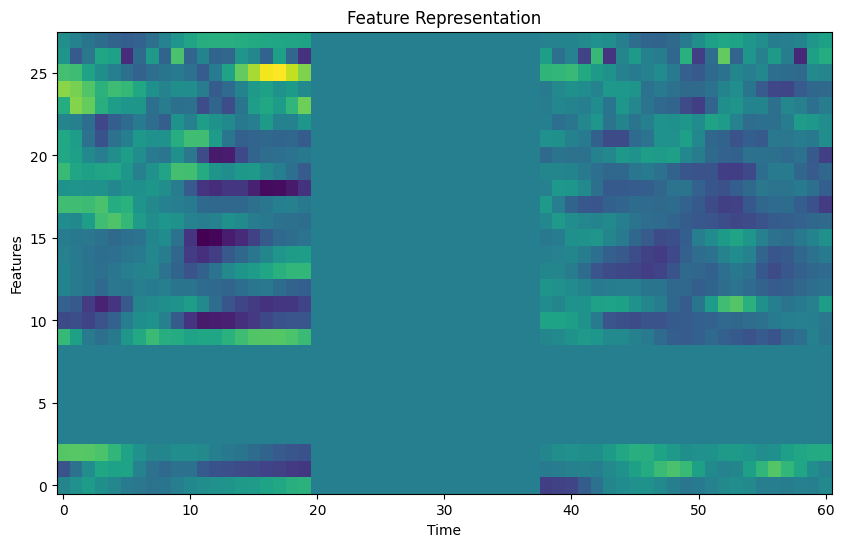

In [50]:
import matplotlib.pyplot as plt

# Testing code to check if your data loaders are working
for i, data in enumerate(train_loader):
    frames, phoneme = data
    print(frames.shape, phoneme.shape)

    # Visualize sample mfcc to inspect and verify everything is correctly done, especially augmentations
    plt.figure(figsize=(10, 6))
    plt.imshow(frames[0].numpy().T, aspect='auto', origin='lower', cmap='viridis')
    plt.xlabel('Time')
    plt.ylabel('Features')
    plt.title('Feature Representation')
    plt.show()

    break

In [51]:
# Testing code to check if your validation data loaders are working
all = []
for i, data in enumerate(val_loader):
    frames, phoneme = data
    all.append(phoneme)
    break

# Network Architecture


This section defines your network architecture for the homework. We have given you a sample architecture that can easily clear the very low cutoff for the early submission deadline.

In [52]:
# This architecture will make you cross the very low cutoff
# However, you need to run a lot of experiments to cross the medium or high cutoff

class Network(nn.Module):
    def __init__(self, input_size, output_size):
        super(Network, self).__init__()

        self.model = nn.Sequential(
            # Input Layer (Starting with 2048 units)
            torch.nn.Linear(input_size, 2048),
            torch.nn.GELU(),
            torch.nn.BatchNorm1d(2048),  # Batch Normalization after the first linear layer

            # Hidden Layer 1
            torch.nn.Linear(2048, 1024),
            torch.nn.GELU(),
            torch.nn.BatchNorm1d(1024),  # Batch Normalization

            # Hidden Layer 2
            torch.nn.Linear(1024, 512),
            torch.nn.GELU(),
            torch.nn.BatchNorm1d(512),   # Batch Normalization

            # Hidden Layer 3
            torch.nn.Linear(512, 256),
            torch.nn.GELU(),
            torch.nn.BatchNorm1d(256),   # Batch Normalization

            # Hidden Layer 4
            torch.nn.Linear(256, 128),
            torch.nn.GELU(),
            torch.nn.BatchNorm1d(128),   # Batch Normalization

            # Hidden Layer 4
            torch.nn.Linear(128, 64),
            torch.nn.GELU(),
            torch.nn.BatchNorm1d(64),   # Batch Normalization

            # Hidden Layer 4
            torch.nn.Linear(64, 32),
            torch.nn.GELU(),
            torch.nn.BatchNorm1d(32),   # Batch Normalization

            # Output Layer
            torch.nn.Linear(32, output_size)
        )

        if config['weight_initialization'] is not None:
            self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                if config["weight_initialization"] == "xavier_normal":
                    torch.nn.init.xavier_normal_(m.weight)
                elif config["weight_initialization"] == "xavier_uniform":
                    torch.nn.init.xavier_uniform_(m.weight)
                elif config["weight_initialization"] == "kaiming_normal":
                    torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                elif config["weight_initialization"] == "kaiming_uniform":
                    torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                elif config["weight_initialization"] == "uniform":
                    torch.nn.init.uniform_(m.weight)
                else:
                    raise ValueError("Invalid weight_initialization value")

                # Initialize bias to 0
                m.bias.data.fill_(0)


    def forward(self, x):
        # Flatten to a 1D vector for each data point
        x = torch.flatten(x, start_dim=1)  # Keeps batch size, flattens the rest

        return self.model(x)

# Define Model, Loss Function and Optimizer

Here we define the model, loss function, optimizer and optionally a learning rate scheduler.

In [53]:
INPUT_SIZE  = (2*config['context'] + 1) * 28 # Why is this the case?
model       = Network(INPUT_SIZE, len(train_data.phonemes)).to(device).cuda()
summary(model, frames.to(device))
# Check number of parameters of your network
# Remember, you are limited to 20 million parameters for HW1 (including ensembles)

----------------------------------------------------------------------------------------------------
Layer                   Kernel Shape         Output Shape         # Params (K)      # Mult-Adds (M)
0_Linear                [1708, 2048]         [2048, 2048]             3,500.03                 3.50
1_GELU                             -         [2048, 2048]                    -                    -
2_BatchNorm1d                 [2048]         [2048, 2048]                 4.10                 0.00
3_Linear                [2048, 1024]         [2048, 1024]             2,098.18                 2.10
4_GELU                             -         [2048, 1024]                    -                    -
5_BatchNorm1d                 [1024]         [2048, 1024]                 2.05                 0.00
6_Linear                 [1024, 512]          [2048, 512]               524.80                 0.52
7_GELU                             -          [2048, 512]                    -                    -

# Define Model, Loss Function and Optimizer

Here we define the model, loss function, optimizer and optionally a learning rate scheduler.

In [54]:
criterion = torch.nn.CrossEntropyLoss() # Defining Loss function.
# We use CE because the task is multi-class classification

# Choose an appropriate optimizer of your choice
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])

# Recommended : Define Scheduler for Learning Rate,
# including but not limited to StepLR, MultiStep, CosineAnnealing, CosineAnnealingWithWarmRestarts, ReduceLROnPlateau, etc.
# You can refer to Pytorch documentation for more information on how to use them.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

# Is your training time very high?
# Look into mixed precision training if your GPU (Tesla T4, V100, etc) can make use of it
# Refer - https://pytorch.org/docs/stable/notes/amp_examples.html
# Mixed Precision Training with AMP for speedup
scaler = torch.amp.GradScaler('cuda', enabled=True)

# Training and Validation Functions

This section covers the training, and validation functions for each epoch of running your experiment with a given model architecture. The code has been provided to you, but we recommend going through the comments to understand the workflow to enable you to write these loops for future HWs.

In [55]:
# CLEAR RAM!!
torch.cuda.empty_cache()
gc.collect()

4098

In [56]:
def train(model, dataloader, optimizer, criterion):

    model.train()
    tloss, tacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Initialize Gradients
        optimizer.zero_grad()

        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        with torch.autocast(device_type=device, dtype=torch.float16):
            ### Forward Propagation
            logits  = model(frames)

            ### Loss Calculation
            loss    = criterion(logits, phonemes)

        ### Backward Propagation
        scaler.scale(loss).backward()

        # OPTIONAL: You can add gradient clipping here, if you face issues of exploding gradients

        ### Gradient Descent
        scaler.step(optimizer)
        scaler.update()

        tloss   += loss.item()
        tacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (i + 1))),
                              acc="{:.04f}%".format(float(tacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()


    batch_bar.close()
    tloss   /= len(train_loader)
    tacc    /= len(train_loader)


    return tloss, tacc

In [57]:
def eval(model, dataloader):

    model.eval() # set model in evaluation mode
    vloss, vacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Move data to device (ideally GPU)
        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        # makes sure that there are no gradients computed as we are not training the model now
        with torch.inference_mode():
            ### Forward Propagation
            logits  = model(frames)
            ### Loss Calculation
            loss    = criterion(logits, phonemes)

        vloss   += loss.item()
        vacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        # Do you think we need loss.backward() and optimizer.step() here?

        batch_bar.set_postfix(loss="{:.04f}".format(float(vloss / (i + 1))),
                              acc="{:.04f}%".format(float(vacc*100 / (i + 1))))
        batch_bar.update()

        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()

    batch_bar.close()
    vloss   /= len(val_loader)
    vacc    /= len(val_loader)

    return vloss, vacc

# Weights and Biases Setup

This section is to enable logging metrics and files with Weights and Biases. Please refer to wandb documentationa and recitation 0 that covers the use of weights and biases for logging, hyperparameter tuning and monitoring your runs for your homeworks. Using this tool makes it very easy to show results when submitting your code and models for homeworks, and also extremely useful for study groups to organize and run ablations under a single team in wandb.

We have written code for you to make use of it out of the box, so that you start using wandb for all your HWs from the beginning.

In [58]:
wandb.login(key="5f84a038383b803c751ee6b0b51eb55ffbf0dcfa") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [59]:
# Create your wandb run
run = wandb.init(
    name    = "first-run1", ### Wandb creates random run names if you skip this field, we recommend you give useful names
    reinit  = True, ### Allows reinitalizing runs when you re-run this cell
    #id     = "", ### Insert specific run id here if you want to resume a previous run
    #resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw1p2", ### Project should be created in your wandb account
    config  = config ### Wandb Config for your run
)

lr,████▂▂▂▁▁▁▁▁▁▁▁
train_acc,▁▄▅▆▇██████████
train_loss,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▅▇▇▇████▇███
valid_loss,█▅▄▄▂▂▂▁▁▁▁▁▁▁▁
lr,0.0
train_acc,78.55992
train_loss,0.66777
val_acc,82.1335
valid_loss,0.53391


In [60]:
### Save your model architecture as a string with str(model)
model_arch  = str(model)

### Save it in a txt file
arch_file   = open("model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

### log it in your wandb run with wandb.save()
wandb.save('model_arch.txt')

['/content/wandb/run-20250123_045008-5ygd13w5/files/model_arch.txt']

# Experiment

Now, it is time to finally run your ablations! Have fun!

In [61]:
# Iterate over number of epochs to train and evaluate your model
torch.cuda.empty_cache()
gc.collect()
wandb.watch(model, log="all")

for epoch in range(config['epochs']):

    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr                 = float(optimizer.param_groups[0]['lr'])
    train_loss, train_acc   = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc       = eval(model, val_loader)

    print("\tTrain Acc {:.04f}%\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_acc*100, train_loss, curr_lr))
    print("\tVal Acc {:.04f}%\tVal Loss {:.04f}".format(val_acc*100, val_loss))

    ## Log metrics at each epoch in your run
    # Optionally, you can log at each batch inside train/eval functions
    # (explore wandb documentation/wandb recitation)
    wandb.log({'train_acc': train_acc*100, 'train_loss': train_loss,'val_acc': val_acc*100, 'valid_loss': val_loss, 'lr': curr_lr})

    # If using a scheduler, step the learning rate here, otherwise comment this line
    # Depending on the scheduler in use, you may or may not need to pass in a metric into the step function, so read the docs well
    scheduler.step(val_acc)


    ## Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best


Epoch 1/15


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 68.2355%	Train Loss 1.0272	 Learning Rate 0.0010000
	Val Acc 73.5883%	Val Loss 0.8191

Epoch 2/15


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 73.2050%	Train Loss 0.8505	 Learning Rate 0.0010000
	Val Acc 78.1733%	Val Loss 0.6625

Epoch 3/15


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 74.4655%	Train Loss 0.8074	 Learning Rate 0.0010000
	Val Acc 78.7877%	Val Loss 0.6430

Epoch 4/15


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 76.8477%	Train Loss 0.7260	 Learning Rate 0.0001000
	Val Acc 81.5468%	Val Loss 0.5527

Epoch 5/15


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 77.4244%	Train Loss 0.7059	 Learning Rate 0.0001000
	Val Acc 81.0208%	Val Loss 0.5691

Epoch 6/15


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 77.7384%	Train Loss 0.6951	 Learning Rate 0.0000100
	Val Acc 81.1300%	Val Loss 0.5655

Epoch 7/15


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 77.7124%	Train Loss 0.6961	 Learning Rate 0.0000100
	Val Acc 81.7541%	Val Loss 0.5465

Epoch 8/15


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 77.8248%	Train Loss 0.6922	 Learning Rate 0.0000010
	Val Acc 81.3730%	Val Loss 0.5578

Epoch 9/15


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 77.7387%	Train Loss 0.6957	 Learning Rate 0.0000010
	Val Acc 80.3965%	Val Loss 0.5896

Epoch 10/15


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 78.0170%	Train Loss 0.6854	 Learning Rate 0.0000001
	Val Acc 81.6636%	Val Loss 0.5490

Epoch 11/15


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 77.9029%	Train Loss 0.6895	 Learning Rate 0.0000001
	Val Acc 81.5524%	Val Loss 0.5532

Epoch 12/15


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 77.7803%	Train Loss 0.6941	 Learning Rate 0.0000000
	Val Acc 81.7829%	Val Loss 0.5452

Epoch 13/15


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 77.7906%	Train Loss 0.6934	 Learning Rate 0.0000000
	Val Acc 79.5812%	Val Loss 0.6159

Epoch 14/15


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 77.8171%	Train Loss 0.6924	 Learning Rate 0.0000000
	Val Acc 81.4935%	Val Loss 0.5539

Epoch 15/15


Train:   0%|          | 0/17623 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 77.8491%	Train Loss 0.6915	 Learning Rate 0.0000000
	Val Acc 81.7274%	Val Loss 0.5462


# Testing and submission to Kaggle

Before we get to the following code, make sure to see the format of submission given in *sample_submission.csv*. Once you have done so, it is time to fill the following function to complete your inference on test data. Refer the eval function from previous cells to get an idea of how to go about completing this function.

In [62]:
def test(model, test_loader, phoneme_index_to_label):
    ### What you call for model to perform inference?
    model.eval() # TODO train or eval?

    ### List to store predicted phonemes of test data
    test_predictions = []

    ### Which mode do you need to avoid gradients?
    with torch.no_grad(): # TODO

        for i, mfccs in enumerate(tqdm(test_loader)):

            mfccs   = mfccs.to(device)

            logits  = model(mfccs)

            ### Get most likely predicted phoneme with argmax
            predicted_phonemes_indices = torch.argmax(logits, dim=1)
            predicted_phonemes = [phoneme_index_to_label[idx.item()] for idx in predicted_phonemes_indices]

            ### How do you store predicted_phonemes with test_predictions? Hint, look at eval
            # Remember the phonemes were converted to their corresponding integer indices earlier, and the results of the argmax is a list of the indices of the predicted phonemes.
            # So how do you get and store the actual predicted phonemes
            # TODO: Store predicted_phonemes
            test_predictions.extend(predicted_phonemes)

    return test_predictions

In [63]:
phoneme_index_to_label = {idx: phoneme for idx, phoneme in enumerate(PHONEMES)}

predictions = test(model, test_loader,phoneme_index_to_label)

  0%|          | 0/945 [00:00<?, ?it/s]

In [64]:
### Create CSV file with predictions
with open("./submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(predictions)):
        f.write("{},{}\n".format(i, predictions[i]))

In [65]:
### Finish your wandb run
run.finish()

lr,███▂▂▁▁▁▁▁▁▁▁▁▁
train_acc,▁▅▅▇███████████
train_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▅█▇▇██▇███▆██
valid_loss,█▄▃▁▂▂▁▁▂▁▁▁▃▁▁
lr,0.0
train_acc,77.84907
train_loss,0.69151
val_acc,81.72737
valid_loss,0.54624


In [66]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-spring-25-hw-1-p-2 -f /content/submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle

100% 19.3M/19.3M [00:02<00:00, 6.85MB/s]
Successfully submitted to 11785_Spring25_HW1P2